<a href="https://colab.research.google.com/github/JaganFoundr/Multi-class_Classification/blob/main/Multi_class_Classification_(Clustering).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing dependencies
import torch
import sklearn
import torch.nn as nn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
#device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#creating data
x_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=2,
                            centers=4,
                            cluster_std=1.5,
                            random_state=42
                            )

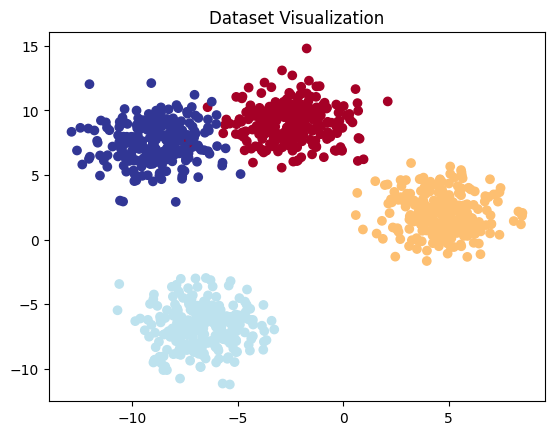

In [4]:
#plotting the dataset
plt.scatter(x=x_blob[:, 0], y=x_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)
plt.title("Dataset Visualization")
plt.show()

In [5]:
#make the data to tensors and move into the device
x=torch.from_numpy(x_blob).type(torch.float).to(device)
y=torch.from_numpy(y_blob).type(torch.LongTensor).to(device)

In [6]:
#splitting the dataset into training and validation dataset
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [7]:
#defining the model
class ClusteringModel(nn.Module):
  def __init__(self, in_features, out_features, hidden_units):
    super().__init__()

    self.linear1=nn.Linear(in_features, hidden_units)
    self.linear2=nn.Linear(hidden_units, hidden_units)
    self.linear3=nn.Linear(hidden_units, out_features)
    self.relu=nn.ReLU()

  def forward(self, x):

    out1 = self.linear1(x)
    f1 = self.relu(out1)
    out2 = self.linear2(f1)
    f2 = self.relu(out2)
    out3 = self.linear3(f2)
    return out3
torch.manual_seed(42)
torch.cuda.manual_seed(43)

model=ClusteringModel(in_features=2, out_features=4, hidden_units=16).to(device)
model

ClusteringModel(
  (linear1): Linear(in_features=2, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=4, bias=True)
  (relu): ReLU()
)

In [8]:
#loss function
loss_function=nn.CrossEntropyLoss()

In [9]:
#optimizer
optimizer=torch.optim.Adam(model.parameters(), lr=0.1)

In [10]:
#accuracy function
def accuracy(output, label):
  _,pred=torch.max(output, dim=1)
  return torch.sum(pred==label).item()/len(pred)*100

In [11]:
#prediction before training, prediction values will in the form of logits
model.eval()
with torch.inference_mode():
  y_logits=model(x_test)

In [12]:
#actual prediction values should be in the form of probablities
#which can be achieved through softmax (for multi-class classification)
#(sigmoid for binary class classification)
predictions = torch.softmax(y_logits,dim=1)
_,pred=torch.max(predictions, dim=1)

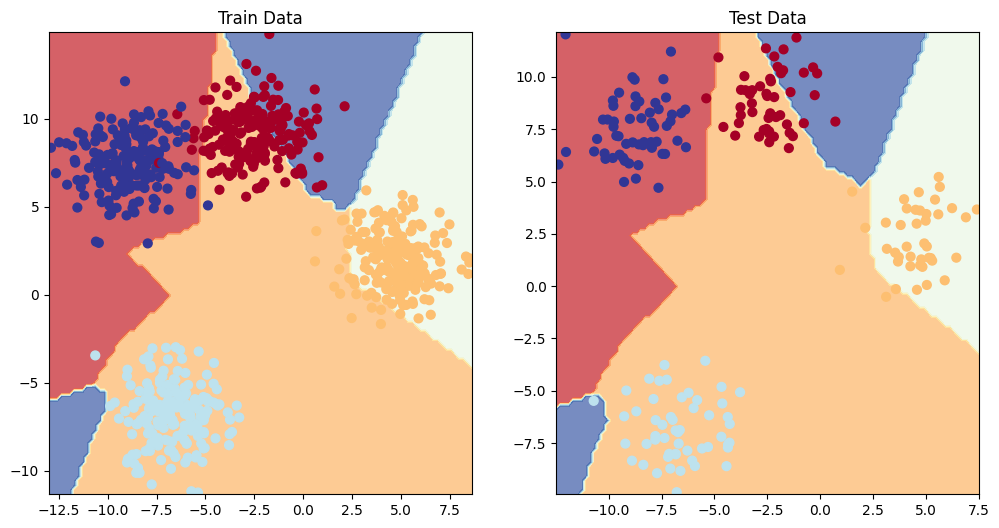

In [13]:
#plotting classification prediction
from pathlib import Path
import requests

# Download Helper Functions
if not Path("helper_functions.py").is_file():
    print("Downloading helper_functions.py...")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train Data")
plot_decision_boundary(model, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test Data")
plot_decision_boundary(model, x_test, y_test)
plt.show()

Epoch 10/100 | Train Loss: 0.0428, Test Loss: 0.0265
Train Accuracy: 98.12%, Test Accuracy: 98.50%
Epoch 20/100 | Train Loss: 0.0254, Test Loss: 0.0182
Train Accuracy: 99.25%, Test Accuracy: 99.50%
Epoch 30/100 | Train Loss: 0.0232, Test Loss: 0.0034
Train Accuracy: 99.38%, Test Accuracy: 100.00%
Epoch 40/100 | Train Loss: 0.0181, Test Loss: 0.0097
Train Accuracy: 99.50%, Test Accuracy: 99.50%
Epoch 50/100 | Train Loss: 0.0174, Test Loss: 0.0061
Train Accuracy: 99.38%, Test Accuracy: 100.00%
Epoch 60/100 | Train Loss: 0.0164, Test Loss: 0.0046
Train Accuracy: 99.50%, Test Accuracy: 100.00%
Epoch 70/100 | Train Loss: 0.0158, Test Loss: 0.0048
Train Accuracy: 99.50%, Test Accuracy: 100.00%
Epoch 80/100 | Train Loss: 0.0152, Test Loss: 0.0042
Train Accuracy: 99.38%, Test Accuracy: 100.00%
Epoch 90/100 | Train Loss: 0.0149, Test Loss: 0.0039
Train Accuracy: 99.38%, Test Accuracy: 100.00%
Epoch 100/100 | Train Loss: 0.0145, Test Loss: 0.0034
Train Accuracy: 99.38%, Test Accuracy: 100.00%


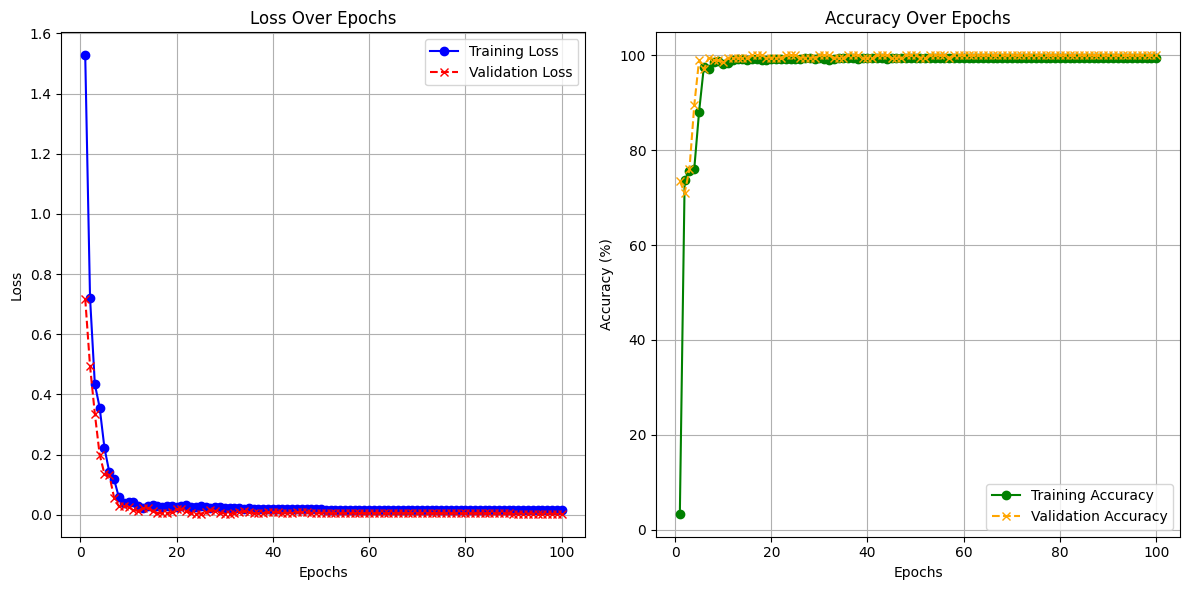

In [14]:
# Training Loop
nepochs = 100
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(nepochs):
    # Training Phase
    model.train()

    training_prediction = model(x_train)
    predictions = torch.softmax(training_prediction,dim=1)
    _,pred=torch.max(predictions, dim=1)

    train_loss = loss_function(training_prediction, y_train)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Evaluation Phase
    model.eval()

    with torch.inference_mode():
        testing_prediction = model(x_test)
        predictions = torch.softmax(testing_prediction,dim=1)
        _,pred=torch.max(predictions, dim=1)

        test_loss = loss_function(testing_prediction, y_test)

    # Compute Accuracies
    train_acc = accuracy(training_prediction, y_train)
    test_acc = accuracy(testing_prediction, y_test)

    # Store Metrics
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    # Print Progress Every 10 Epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{nepochs} | Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
        print(f"Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%")

# Plot Training and Validation Metrics
epochs = range(1, nepochs + 1)
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss", color='blue', marker='o')
plt.plot(epochs, test_losses, label="Validation Loss", color='red', linestyle='--', marker='x')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Training Accuracy", color='green', marker='o')
plt.plot(epochs, test_accuracies, label="Validation Accuracy", color='orange', linestyle='--', marker='x')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

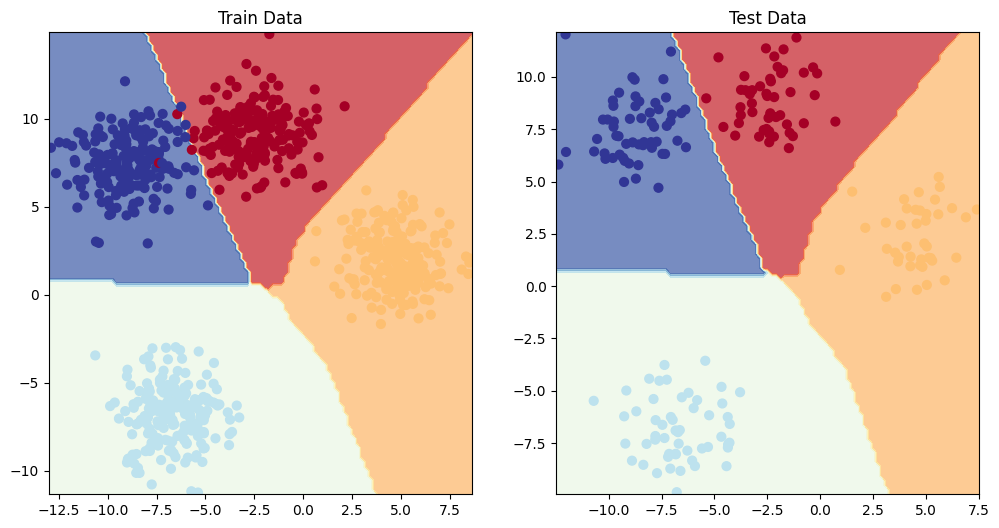

In [15]:
#plotting classification prediction
from pathlib import Path
import requests

# Download Helper Functions
if not Path("helper_functions.py").is_file():
    print("Downloading helper_functions.py...")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train Data")
plot_decision_boundary(model, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test Data")
plot_decision_boundary(model, x_test, y_test)
plt.show()